### Counterfactual explanation on Diabetes dataset

This is an example of the basic counterfactual explainer `CounterfactualExplainer` for tabular data. It only supports continuous-valued features. If using this explainer, please cite the paper "Counterfactual Explanations without Opening the Black Box: Automated Decisions and the GDPR, Sandra Wachter, Brent Mittelstadt, Chris Russell, https://arxiv.org/abs/1711.00399".

In [1]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from omnixai.data.tabular import Tabular
from omnixai.explainers.tabular import CounterfactualExplainer

The dataset considered here is the Diabetes dataset (https://archive.ics.uci.edu/ml/datasets/diabetes). We convert all the features into continuous-valued features.

In [3]:
def diabetes_data(file_path):
    data = pd.read_csv(file_path)
    data = data.replace(
        to_replace=['Yes', 'No', 'Positive', 'Negative', 'Male', 'Female'],
        value=[1, 0, 1, 0, 1, 0]
    )
    features = [
        'Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
        'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
        'Itching', 'Irritability', 'delayed healing', 'partial paresis',
        'muscle stiffness', 'Alopecia', 'Obesity']

    y = data['class']
    data = data.drop(['class'], axis=1)
    x_train_un, x_test_un, y_train, y_test = \
        train_test_split(data, y, test_size=0.2, random_state=2, stratify=y)

    sc = StandardScaler()
    x_train = sc.fit_transform(x_train_un)
    x_test = sc.transform(x_test_un)

    x_train = x_train.astype(np.float32)
    y_train = y_train.to_numpy()
    x_test = x_test.astype(np.float32)
    y_test = y_test.to_numpy()

    return x_train, y_train, x_test, y_test, features

In this example, we apply a tensorflow model for this diabetes prediction task. The model is a feedforward network with two hidden layers.

In [4]:
def train_tf_model(x_train, y_train, x_test, y_test):
    y_train = tf.keras.utils.to_categorical(y_train, 2)
    y_test = tf.keras.utils.to_categorical(y_test, 2)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(16,)))
    model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.softplus))
    model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.softplus))
    model.add(tf.keras.layers.Dense(units=2, activation=None))

    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.1,
        decay_steps=1,
        decay_rate=0.99,
        staircase=True
    )
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=learning_rate, 
        momentum=0.9, 
        nesterov=True
    )
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=256, epochs=200, verbose=0)
    train_loss, train_accuracy = model.evaluate(x_train, y_train, batch_size=51, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, batch_size=51, verbose=0)

    print('Train loss: {:.4f}, train accuracy: {:.4f}'.format(train_loss, train_accuracy))
    print('Test loss:  {:.4f}, test accuracy:  {:.4f}'.format(test_loss, test_accuracy))
    return model

We then load the dataset and train the tensorflow model defined above. Similar to other tabular explainers, we use `Tabular` to represent a tabular dataset used for initializing the explainer.

In [5]:
file_path = '../data/diabetes.csv'
x_train, y_train, x_test, y_test, feature_names = diabetes_data(file_path)
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape:  {}'.format(x_test.shape))

model = train_tf_model(x_train, y_train, x_test, y_test)
# Used for initializing the explainer
tabular_data = Tabular(
    x_train,
    feature_columns=feature_names,
)

x_train shape: (416, 16)
x_test shape:  (104, 16)
Train loss: 0.0631, train accuracy: 0.9856
Test loss:  0.0568, test accuracy:  0.9808


To initialize a `CounterfactualExplainer` explainer, we need to set:
  
  - `training_data`: The data used to extract information such as medians of continuous-valued features. ``training_data`` can be the training dataset for training the machine learning model. If the training dataset is large, ``training_data`` can be a subset of it by applying `omnixai.sampler.tabular.Sampler.subsample`.
  - `predict_function`: The prediction function corresponding to the model.
  - `mode`: The task type, e.g., "classification" or "regression".
  
In this example, the prediction function is a tensorflow model which is callable, so we can set `predict_function=model`.

Binary step: 5 |███████████████████████████████████████-| 99.9% 

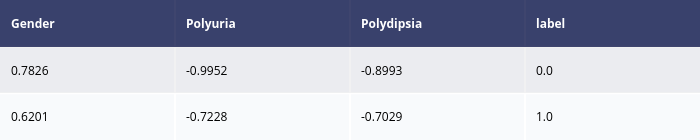

In [6]:
explainer = CounterfactualExplainer(
    training_data=tabular_data,
    predict_function=model
)
explanations = explainer.explain(x_test[:1])
explanations.ipython_plot()